<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Ensembles and Random Forests
 
_Author: Joseph Nelson (DC)_

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

---

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

<a id="introduction"></a>
## Introduction

### What is Ensembling?

**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model. For example, given predictions from several models we could:

- **Regression:** Take the average of the predictions.
- **Classification:** Take a vote and use the most common prediction.

For ensembling to work well, the models must be:

- **Accurate:** They outperform the null model.
- **Independent:** Their predictions are generated using different processes.

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when you average the models.

There are two basic **methods for ensembling:**

- Manually ensembling your individual models.
- Using a standard "meta-model" that does ensembling internally.

<a id="part-one"></a>
## Part 1: Manual Ensembling

What makes an effective manual ensemble?

- Different types of **models**.
- Different combinations of **features**.
- Different **tuning parameters**.

![Machine learning flowchart](../assets/images/crowdflower_ensembling.jpg)

*Machine learning flowchart created by the [winner](https://github.com/ChenglongChen/Kaggle_CrowdFlower) of Kaggle's [CrowdFlower competition](https://www.kaggle.com/c/crowdflower-search-relevance)*.

### Comparing Ensembling With a Single-Model Approach

**Advantage of ensembling:** it can increase predictive accuracy.

**Disadvantages of ensembling:**

- It decreases interpretability.
- It takes longer to train.
- It takes longer to predict.
- It is more complex to automate and maintain, particularly with manual ensembling.

Outside of machine learning competitions, you have to weigh gains in accuracy against added complexity.

<a id="part-two"></a>
## Part 2: Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially because of **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general-purpose procedure for reducing the variance of a machine learning method but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

A **bootstrap sample** is a random sample with replacement. So, it has the same size as the original sample but might duplicate some of the original observations.

In [3]:

np.random.seed(1)

In [4]:
# Create an array of 1 through 20.
# /scrub/
nums = np.arange(1, 21)
print(nums)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [5]:
# Sample that array 20 times with replacement.
# /scrub/
print(np.random.choice(a=nums, size=20, replace=True))

[ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


**How does bagging work (for decision trees)?**

1. Grow B trees using B bootstrap samples from the training data.
2. Train each tree on its bootstrap sample and make predictions.
3. Combine the predictions:
    - Average the predictions for **regression trees**.
    - Take a vote for **classification trees**.

**Notes:**

- **Each bootstrap sample** is typically the same size as the original training set. (It may contain repeated rows.)
- **B** should be a large enough value that the error seems to have "stabilized".
- The trees are **grown deep** so that they have low bias/high variance.

Training multiple trees through bagging can give more consistent results than training a single tree, thereby reducing variance.

<a id="manual-bagged"></a>
## Manually Implementing Bagged Decision Trees (with B=10)

In [6]:
# Read in and prepare the vehicle training data.
path = Path('..', 'assets', 'data', 'vehicles_train.csv')
train = pd.read_csv(path)

In [14]:
train.shape

(14, 5)

In [7]:
# Transform "vtype" to "is_truck"
# /scrub/
train.loc[:, 'is_truck'] = train.loc[:, 'vtype'].map({'car':0, 'truck':1})
train.drop('vtype', axis=1, inplace=True)
train

,price,year,miles,doors,is_truck
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [8]:
# Set a seed for reproducibility.
np.random.seed(123)

In [9]:
# Create ten bootstrap samples (which will be used to select rows from the DataFrame).
# /scrub/
samples = [np.random.choice(a=14, size=14, replace=True) for _ in range(1, 11)]
samples

[array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1]),
 array([ 9,  0,  0,  9,  3, 13,  4,  0,  0,  4,  1,  7,  3,  2]),
 array([ 4,  7,  2,  4,  8, 13,  0,  7,  9,  3, 12, 12,  4,  6]),
 array([ 1,  5,  6, 11,  2,  1, 12,  8,  3, 10,  5,  0, 11,  2]),
 array([10, 10,  6, 13,  2,  4, 11, 11, 13, 12,  4,  6, 13,  3]),
 array([10,  0,  6,  4,  7, 11,  6,  7,  1, 11, 10,  5,  7,  9]),
 array([ 2,  4,  8,  1, 12,  2,  1,  1,  3, 12,  5,  9,  0,  8]),
 array([11,  1,  6,  3,  3, 11,  5,  9,  7,  9,  2,  3, 11,  3]),
 array([ 3,  8,  6,  9,  7,  6,  3,  9,  6, 12,  6, 11,  6,  1]),
 array([13, 10,  3,  4,  3,  1, 13,  0,  5,  8, 13,  6, 11,  8])]

In [10]:
# Show the rows for the first decision tree.
# /scrub/
train.iloc[samples[0], :]

,price,year,miles,doors,is_truck
13,1300,1997,138000,4,0
2,13000,2010,73500,4,0
12,1800,1999,163000,2,1
2,13000,2010,73500,4,0
6,3000,2004,177000,4,0
1,14000,2010,30000,2,0
3,9500,2009,78000,4,0
10,2500,2003,190000,2,1
11,5000,2001,62000,4,0
9,1900,2003,160000,4,0


In [12]:
# Read in and prepare the vehicle testing data.
# /scrub/
path = Path('..', 'assets', 'data', 'vehicles_test.csv')
test = pd.read_csv(path)
test.loc[:, 'is_truck'] = test.loc[:, 'vtype'].map({'car':0, 'truck':1})
test.drop('vtype', axis=1, inplace=True)
test

,price,year,miles,doors,is_truck
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [13]:
test.shape

(3, 5)

In [12]:
# Import decision tree regressor
# /scrub/
from sklearn.tree import DecisionTreeRegressor

In [13]:
# Grow each tree deep.
# /scrub/
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

In [14]:
# Define testing data.
# /scrub/
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [15]:
# Grow one tree for each bootstrap sample and make predictions on testing data.
# /scrub/
predictions = []

for sample in samples:
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

In [16]:
# Convert predictions from list to NumPy array.
# /scrub/
predictions = np.array(predictions)
predictions

array([[ 1300.,  5000., 14000.],
       [ 1300.,  1300., 13000.],
       [ 3000.,  3000., 13000.],
       [ 4000.,  5000., 13000.],
       [ 1300.,  5000., 13000.],
       [ 4000.,  5000., 14000.],
       [ 4000.,  4000., 13000.],
       [ 4000.,  5000., 13000.],
       [ 3000.,  5000.,  9500.],
       [ 4000.,  5000.,  9000.]])

In [17]:
# Average predictions.
# /scrub/
np.mean(predictions, axis=0)

array([ 2990.,  4330., 12450.])

In [18]:
# Calculate RMSE.
# /scrub/
from sklearn import metrics

y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

998.5823284370031

<a id="manual-sklearn"></a>
## Bagged Decision Trees in `scikit-learn` (with B=500)

In [19]:
# Define the training and testing sets.
# /scrub/
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [10]:
train.iloc[:,0]

0     22000
1     14000
2     13000
3      9500
4      9000
5      4000
6      3000
7      2000
8      3000
9      1900
10     2500
11     5000
12     1800
13     1300
Name: price, dtype: int64

In [20]:
# Instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator."
# /scrub/

from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=1)

In [21]:
# Fit and predict.
# /scrub/

bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([ 3344.2,  5395. , 12902. ])

In [22]:
# Calculate RMSE.
# /scrub/
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

657.8000304043775

<a id="oos-error"></a>
## Estimating Out-of-Sample Error

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

For each tree, the **unused observations** are called "out-of-bag" observations.

In [23]:
# Show the first bootstrap sample.
# /scrub/
samples[0]

array([13,  2, 12,  2,  6,  1,  3, 10, 11,  9,  6,  1,  0,  1])

In [24]:
# Show the "in-bag" observations for each sample.
# /scrub/
for sample in samples:
    print(set(sample))

{0, 1, 2, 3, 6, 9, 10, 11, 12, 13}
{0, 1, 2, 3, 4, 7, 9, 13}
{0, 2, 3, 4, 6, 7, 8, 9, 12, 13}
{0, 1, 2, 3, 5, 6, 8, 10, 11, 12}
{2, 3, 4, 6, 10, 11, 12, 13}
{0, 1, 4, 5, 6, 7, 9, 10, 11}
{0, 1, 2, 3, 4, 5, 8, 9, 12}
{1, 2, 3, 5, 6, 7, 9, 11}
{1, 3, 6, 7, 8, 9, 11, 12}
{0, 1, 3, 4, 5, 6, 8, 10, 11, 13}


In [25]:
# Show the "out-of-bag" observations for each sample.
# /scrub/
for sample in samples:
    print(sorted(set(range(14)) - set(sample)))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]
[4, 7, 9, 13]
[0, 1, 5, 7, 8, 9]
[2, 3, 8, 12, 13]
[6, 7, 10, 11, 13]
[0, 4, 8, 10, 12, 13]
[0, 2, 4, 5, 10, 13]
[2, 7, 9, 12]


**Calculating "out-of-bag error:"**

1. For each observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a vote (for classification).
2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When B is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [26]:
# Compute the out-of-bag R-squared score (not MSE, unfortunately) for B=500.
# /scrub/
bagreg.oob_score_

0.7986955133989982

### Estimating Feature Importance

Bagging increases **predictive accuracy** but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:

- **Bagged regression trees:** Calculate the total amount that **MSE** decreases due to splits over a given feature, averaged over all trees
- **Bagged classification trees:** Calculate the total amount that **Gini index** decreases due to splits over a given feature, averaged over all trees

**Exercise (6 mins.)**

In your own words...

- What is ensembling?

/scrub/

Combining the predictions from several different models, e.g. by averaging regression models or having classification models vote.

- How do bagged classification trees work?

/scrub/

A bagged classification tree is a collection of classification trees developed on bootstrap samples of the original data set -- that is, samples of that dataset that are the same size as the original dataset but are drawn with replacement.

- What is out-of-bag error?

/scrub/

Out-of-bag error is the aggregate error rate of the components of a bagged model on the data that was not included in those components' bootstrap samples.

- Compare and contrast ensembling and K-fold cross validation in terms of both process and aims.

/scrub/

- Esembling:
    - Process: Create *multiple* models and then combine them into one "meta-model" by pooling their predictions.
    - Aims: Better performance.
- K-fold cross validation:
    - Process: Fit *one* model multiple times using a different test set each time.
    - Aims: Better estimates of performance on unseen data.

Both processes involve multiple fitting steps, but otherwise they are quite difference in both process and aims.

$\blacksquare$

<a id="part-three"></a>
## Part 3: Random Forests

Random Forests offer a **slight variation on bagged trees** that usually gives better performance:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, each time a split is considered, a **random sample of m features** is chosen as split candidates from the **full set of p features**. The split is only allowed to use **one of those m features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, m is typically chosen to be the square root of p.
    - For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is **one very strong feature** in the data set. When using bagged trees, most of the trees will use that feature as the top split, resulting in an ensemble of similar trees that are **highly correlated**.
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- By randomly leaving out candidate features from each split, **random forests "decorrelate" the trees** to the extent that the averaging process can reduce the variance of the resulting model.
- Another way of looking at it is that sometimes one or two strong features dominate every tree in bagging, resulting in essentially the same tree as every predictor. (This is what was meant when saying the trees could be highly correlated.) By using a subset of features to generate each tree, we get a wider variety of predictive trees that do not all use the same dominant features.

<a id="part-four"></a>
## Part 4: Building and Tuning Decision Trees and Random Forests

In this section, we will use the sklearn implementation of random forests.

- Major League Baseball player data from 1986-87: [data](https://github.com/justmarkham/DAT8/blob/master/data/hitters.csv), [data dictionary](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf) (page 7)
- Each observation represents a player.
- **Goal:** Predict player salary.

### Preparing the Data

In [27]:
# Read in the data.
path = Path('..', 'assets', 'data', 'hitters.csv')
hitters = pd.read_csv(path)

In [28]:
# Remove rows with missing values.
# /scrub/
hitters.dropna(inplace=True)

In [29]:
# Encode categorical variables as integers.
# /scrub/

hitters = pd.get_dummies(hitters, columns=['League', 'Division', 'NewLeague'], drop_first=True)

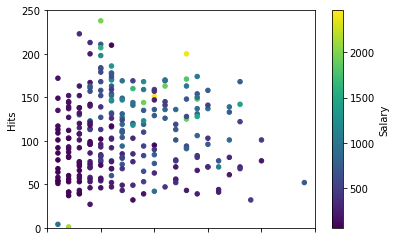

In [30]:
# Create a scatter plot of hits vs years, colored by salary
# /scrub/
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='viridis', xlim=(0, 25), ylim=(0, 250));

In [31]:
# Define features: Exclude career statistics (which start with "C") and the response (salary).
# /scrub/
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'PutOuts',
       'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')

In [32]:
# Define X and y.
# /scrub/
X = hitters.loc[:, feature_cols]
y = hitters.loc[:, 'Salary']

<a id="decision-tree"></a>
## Predicting Salary With a Decision Tree

Let's first recall how we might predict salary using a single decision tree.

We'll first find the best **max_depth** for a decision tree using cross-validation:

In [33]:
# List of values to try for max_depth:
# /scrub/
max_depth_range = list(range(1, 21))

In [34]:
# Use 10-fold cross-validation with each value of max_depth.
# /scrub/
RMSE_scores = []

from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

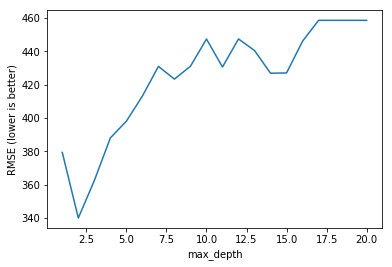

In [35]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
# /scrub/
fig, ax = plt.subplots()
ax.plot(max_depth_range, RMSE_scores);
ax.set_xlabel('max_depth');
ax.set_ylabel('RMSE (lower is better)');

In [36]:
# Show the best RMSE and the corresponding max_depth.
# /scrub/
sorted(zip(RMSE_scores, max_depth_range))[0]

(340.034168704752, 2)

In [37]:
# max_depth=2 was best, so fit a tree using that parameter.
# /scrub/
treereg = DecisionTreeRegressor(max_depth=2, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [38]:
# Compute feature importances.
# /scrub/
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values(by='importance')

,feature,importance
0,AtBat,0.000000
2,HmRun,0.000000
3,Runs,0.000000
4,RBI,0.000000
5,Walks,0.000000
7,PutOuts,0.000000
8,Assists,0.000000
9,Errors,0.000000
10,League_N,0.000000
11,Division_W,0.000000


<a id="random-forest-demo"></a>
## Predicting Salary With a Random Forest

### Fitting a Random Forest With the Best Parameters

In [39]:
# Import random forest regressor
# /scrub/
from sklearn.ensemble import RandomForestRegressor

In [40]:
# max_features=5 is best and n_estimators=150 is sufficiently large.
# /scrub/
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=None, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [41]:
# Compute feature importances.
# /scrub/
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
12,NewLeague_N,0.004405
10,League_N,0.004480
11,Division_W,0.009814
8,Assists,0.026757
9,Errors,0.034428
2,HmRun,0.044038
7,PutOuts,0.070237
3,Runs,0.078334
0,AtBat,0.095918
4,RBI,0.127788


In [42]:
# Compute the out-of-bag R-squared score.
# /scrub/
print((rfreg.oob_score_))

0.5287380652267777


In [43]:
# Find the average RMSE.
# /scrub/
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

292.3802272796587

<a id="comparing"></a>
## Comparing Random Forests With Decision Trees

**Advantages of random forests:**

- Their performance is often competitive with the best supervised learning methods, unlike that of decision trees.
- They provide a more reliable estimate of feature importance.
- They allow you to estimate out-of-sample error without using train/test split or cross-validation.

**Disadvantages of random forests:**

- They are less interpretable.
- They are slower to train.
- They are slower to predict.

**Exercise (12 mins., pair programming)**

- How does a random forest differ from an ordinary bagged decision tree?

/scrub/

A random forest uses a random subset of features at each split in addition to using bootstrap aggregation.

- Use a `RandomForestClassifier` estimator to predict who survives on the Titanic. Use five-fold cross-validation to evaluate its accuracy.

*Tip:* For your first model, just use the numeric columns without missing values as-is as your features. You can mess with missing data, dummy coding, and additional feature engineering later.

In [44]:
path = Path('..', 'assets', 'data', 'titanic.csv')
titanic = pd.read_csv(path)

In [45]:
# /scrub/
from sklearn.ensemble import RandomForestClassifier

In [46]:
# /scrub/
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
# /scrub/
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [48]:
# /scrub/
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [49]:
# /scrub/
feature_cols = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare']
X = titanic.loc[:, feature_cols]
y = titanic.loc[:, 'Survived']

In [50]:
# /scrub/
rfc = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc, X, y, cv=5)
print(scores)
print(scores.mean())

[0.60893855 0.55307263 0.70786517 0.7247191  0.68926554]
0.6567721959140885


- **BONUS:** Find a way to change your model that improves its five-fold cross-validation accuracy.

*Tip:* If you have a small gap between training-set performance and test-set performance, then focus on decreasing bias. Otherwise, focus on decreasing variance.

$\blacksquare$

<a id="tuning"></a>
## Optional: Hyperparameter Tuning

In [51]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Tuning n_estimators

One important tuning parameter is **n_estimators**, which represents the number of trees that should be grown. This should be a large enough value that the error seems to have "stabilized."

In [52]:
# List of values to try for n_estimators:
estimator_range = list(range(10, 310, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

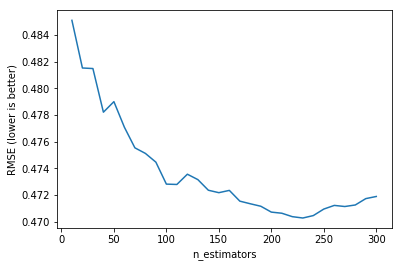

In [53]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

fig, ax = plt.subplots()
ax.plot(estimator_range, RMSE_scores);
ax.set_xlabel('n_estimators');
ax.set_ylabel('RMSE (lower is better)');

**Adding more trees will only help average performance, with diminishing returns.**

### Tuning max_features

The other important tuning parameter is **max_features**, which represents the number of features that should be considered at each split.

In [54]:
# List of values to try for max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

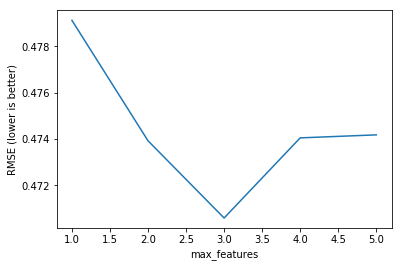

In [55]:
# Plot max_features (x-axis) versus RMSE (y-axis).
fig, ax = plt.subplots()
ax.plot(feature_range, RMSE_scores);
ax.set_xlabel('max_features');
ax.set_ylabel('RMSE (lower is better)');

In [56]:
# Show the best RMSE and the corresponding max_features.
sorted(zip(RMSE_scores, feature_range))[0]

(0.4705865489758527, 3)

<a id="summary"></a>
## Summary

**Which model is best?** The best classifier for a particular task is task-dependent. In many business cases, interpretability is more important than accuracy. So, decision trees may be preferred. In other cases, accuracy on unseen data might be paramount, in which case random forests would likely be better (since they typically overfit less). 

---

**In this lesson:**

- We looked at ensemble models.
- We saw how decision trees could be extended using two ensemble techniques -- bagging and random forests.
- We looked at methods of evaluating feature importance and tuning parameters.